# Import Libraries

In [39]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Sun Apr 12 00:40:09 2020


In [40]:
import src
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.utils.utils as utils
import src.train.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.preprochelper as preprochelper
from src.utils import cifar_mean,cifar_std

%config IPCompleter.greedy=True
%reload_ext autoreload

In [41]:
%autoreload 2  # Autoreload all modules

In [42]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)
    
printgpuinfo()

Sun Apr 12 00:40:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   81C    P2    43W /  N/A |   5071MiB /  8117MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [43]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    ram_gb_avail = virtual_memory().available / 1e9
    ram_gb_used = virtual_memory().active / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    print('Your runtime has {:.1f} gigabytes of free RAM\n'.format(ram_gb_avail))
    print('Your runtime has {:.1f} gigabytes of used RAM\n'.format(ram_gb_used))    
showsysteminfo()

Your runtime has 16.7 gigabytes of available RAM

Your runtime has 4.5 gigabytes of free RAM

Your runtime has 13.0 gigabytes of used RAM



In [44]:
import torch
print(torch.__version__)

1.4.0


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True
512


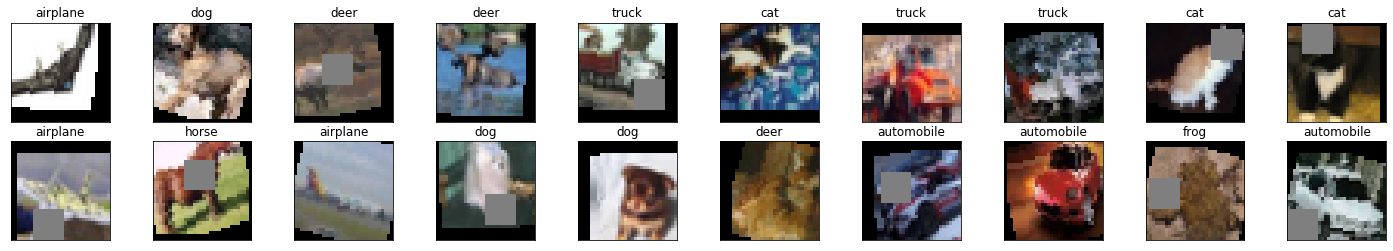

In [45]:
batch_size = 512
# compose_train, compose_test = preprochelper.PreprocHelper.getalbumentationstraintesttransforms(cifar_mean,cifar_std)
train_transforms, test_transforms = preprochelper.PreprocHelper.getpytorchtransforms((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
ds = dst.Dataset()
train_dataset = ds.gettraindataset(train_transforms)
test_dataset = ds.gettestdataset(test_transforms)

# train_dataset = ds.gettraindataset(compose_train)
# test_dataset = ds.gettestdataset(compose_test)

dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

# specify the image classes
classes = ds.getclassesinCIFAR10dataset()
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [46]:
cnn_model, device = utils.Utils.createA11CustomResnetModel()
train_model = train.TrainModel()
train_model.showmodelsummary(cnn_model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-

In [47]:
epochs = 25

In [48]:
from torch.optim.lr_scheduler import LambdaLR
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.01, momentum=0.9, weight_decay=0, nesterov=True)
lambda1 = lambda epoch: (epoch * 0.4)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])

In [49]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for epoch in range(1, epochs+1):
    print("EPOCH:", epoch)
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(model=cnn_model, device=device, test_loader=test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch, lr_data=lr_data)
#     scheduler.step(t_acc_epoch)
    scheduler.step()
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch + 1)  # print LR for different epochs
        lr_data.append(param_groups['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=3.3572511672973633 Batch_id=97 Accuracy=11.74: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.0055, Accuracy: 1075/10000 (10.75%)

Validation accuracy increased (0.000000 --> 10.750000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.004  for epoch:  2
EPOCH: 2


Loss=2.9918723106384277 Batch_id=97 Accuracy=12.38: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 0.0064, Accuracy: 1135/10000 (11.35%)

Validation accuracy increased (10.750000 --> 11.350000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.008  for epoch:  3
EPOCH: 3


Loss=2.98757004737854 Batch_id=97 Accuracy=15.74: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]  



Test set: Average loss: 0.0044, Accuracy: 2081/10000 (20.81%)

Validation accuracy increased (11.350000 --> 20.810000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.012000000000000002  for epoch:  4
EPOCH: 4


Loss=2.003329277038574 Batch_id=97 Accuracy=23.13: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s] 



Test set: Average loss: 0.0042, Accuracy: 2801/10000 (28.01%)

Validation accuracy increased (20.810000 --> 28.010000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.016  for epoch:  5
EPOCH: 5


Loss=1.7650742530822754 Batch_id=97 Accuracy=31.37: 100%|██████████| 98/98 [00:41<00:00,  2.39it/s]



Test set: Average loss: 0.0034, Accuracy: 3950/10000 (39.50%)

Validation accuracy increased (28.010000 --> 39.500000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.02  for epoch:  6
EPOCH: 6


Loss=1.937161922454834 Batch_id=97 Accuracy=39.12: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s] 



Test set: Average loss: 0.0046, Accuracy: 4043/10000 (40.43%)

Validation accuracy increased (39.500000 --> 40.430000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.024000000000000004  for epoch:  7
EPOCH: 7


Loss=1.3356096744537354 Batch_id=97 Accuracy=46.83: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0028, Accuracy: 5174/10000 (51.74%)

Validation accuracy increased (40.430000 --> 51.740000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.028000000000000004  for epoch:  8
EPOCH: 8


Loss=1.3566744327545166 Batch_id=97 Accuracy=53.78: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0031, Accuracy: 5456/10000 (54.56%)

Validation accuracy increased (51.740000 --> 54.560000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.032  for epoch:  9
EPOCH: 9


Loss=1.1842864751815796 Batch_id=97 Accuracy=59.21: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0023, Accuracy: 6450/10000 (64.50%)

Validation accuracy increased (54.560000 --> 64.500000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.036000000000000004  for epoch:  10
EPOCH: 10


Loss=1.37844979763031 Batch_id=97 Accuracy=63.32: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]  



Test set: Average loss: 0.0019, Accuracy: 6930/10000 (69.30%)

Validation accuracy increased (64.500000 --> 69.300000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.04  for epoch:  11
EPOCH: 11


Loss=0.9221148490905762 Batch_id=97 Accuracy=63.49: 100%|██████████| 98/98 [00:40<00:00,  2.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6913/10000 (69.13%)

Learning rate = 0.044000000000000004  for epoch:  12
EPOCH: 12


Loss=0.9979541301727295 Batch_id=97 Accuracy=68.55: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]



Test set: Average loss: 0.0016, Accuracy: 7406/10000 (74.06%)

Validation accuracy increased (69.300000 --> 74.060000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.04800000000000001  for epoch:  13
EPOCH: 13


Loss=0.7765510082244873 Batch_id=97 Accuracy=70.74: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]



Test set: Average loss: 0.0016, Accuracy: 7504/10000 (75.04%)

Validation accuracy increased (74.060000 --> 75.040000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.052000000000000005  for epoch:  14
EPOCH: 14


Loss=0.84760582447052 Batch_id=97 Accuracy=72.57: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]  



Test set: Average loss: 0.0016, Accuracy: 7564/10000 (75.64%)

Validation accuracy increased (75.040000 --> 75.640000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.05600000000000001  for epoch:  15
EPOCH: 15


Loss=0.5515940189361572 Batch_id=97 Accuracy=74.55: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0013, Accuracy: 7920/10000 (79.20%)

Validation accuracy increased (75.640000 --> 79.200000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  16
EPOCH: 16


Loss=0.6712943315505981 Batch_id=97 Accuracy=75.96: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0015, Accuracy: 7932/10000 (79.32%)

Validation accuracy increased (79.200000 --> 79.320000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.064  for epoch:  17
EPOCH: 17


Loss=0.6150056719779968 Batch_id=97 Accuracy=77.74: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]



Test set: Average loss: 0.0012, Accuracy: 8084/10000 (80.84%)

Validation accuracy increased (79.320000 --> 80.840000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.068  for epoch:  18
EPOCH: 18


Loss=0.5697978734970093 Batch_id=97 Accuracy=78.83: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.0011, Accuracy: 8263/10000 (82.63%)

Validation accuracy increased (80.840000 --> 82.630000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  19
EPOCH: 19


Loss=0.6224785447120667 Batch_id=97 Accuracy=76.04: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s] 
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8183/10000 (81.83%)

Learning rate = 0.07600000000000001  for epoch:  20
EPOCH: 20


Loss=0.6408442258834839 Batch_id=97 Accuracy=79.02: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7998/10000 (79.98%)

Learning rate = 0.08  for epoch:  21
EPOCH: 21


Loss=0.49001434445381165 Batch_id=97 Accuracy=80.47: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8259/10000 (82.59%)

Learning rate = 0.084  for epoch:  22
EPOCH: 22


Loss=0.4941288232803345 Batch_id=97 Accuracy=81.74: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s] 



Test set: Average loss: 0.0010, Accuracy: 8444/10000 (84.44%)

Validation accuracy increased (82.630000 --> 84.440000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.08800000000000001  for epoch:  23
EPOCH: 23


Loss=0.4816761612892151 Batch_id=97 Accuracy=82.30: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s] 
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8419/10000 (84.19%)

Learning rate = 0.09200000000000001  for epoch:  24
EPOCH: 24


Loss=0.48242315649986267 Batch_id=97 Accuracy=83.07: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0009, Accuracy: 8448/10000 (84.48%)

Validation accuracy increased (84.440000 --> 84.480000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Learning rate = 0.09600000000000002  for epoch:  25
EPOCH: 25


Loss=0.516751229763031 Batch_id=97 Accuracy=83.88: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]  



Test set: Average loss: 0.0010, Accuracy: 8428/10000 (84.28%)

Learning rate = 0.1  for epoch:  26


In [50]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/learningratefinder.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses,lr_data=lr_data,class_correct=class_correct,class_total=class_total)

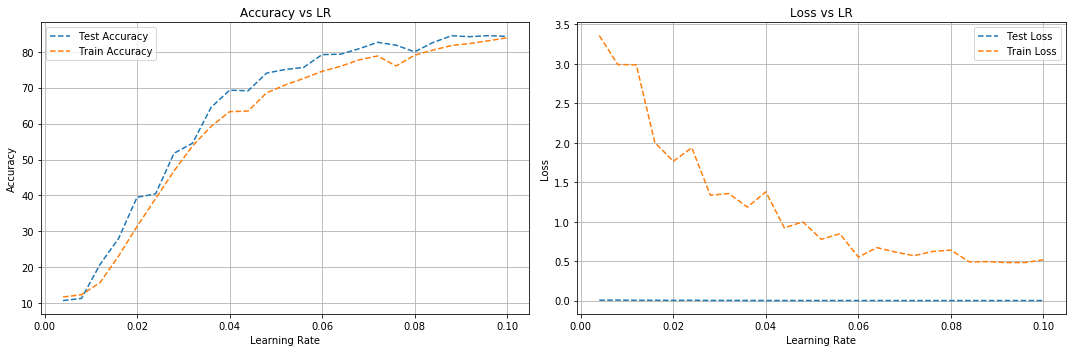

In [51]:
plotdata.PlotData.plotlrrangetestgraph(lr_data,test_acc,train_acc,test_losses,train_losses)

In [1]:
import src
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.utils.utils as utils
import src.train.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.preprochelper as preprochelper
from src.utils import cifar_mean,cifar_std

%config IPCompleter.greedy=True
%reload_ext autoreload
%autoreload 2  # Autoreload all modules

In [2]:
# LR = 0.0705 at max accuracy 91.27%
lr_max = round(0.092,5)
print("lrmax = {}".format(lr_max))
lr_min = round(lr_max / 13,5)
print("lrmin = {}".format(lr_min))
epochs = 24
maxlrepoch = 5

lrmax = 0.092
lrmin = 0.00708


In [ ]:
# Additional function to see where on the cycle we are
def relative(it, maxlrepoch, epochs, minlr, maxlr): 
        delta = maxlr - minlr
        deltaone = delta / (maxlrepoch - 1)
        deltatwo = delta / (epochs - maxlrepoch)

        if it < maxlrepoch:
            val = minlr + (deltaone * it)                                   
            return val
        else:             
            val = maxlr - ((it - maxlrepoch + 1) * deltatwo)            
            return val

def cyclical_lr(maxlrepoch, epochs, minlr, maxlr):
        lr_lambda = lambda it: relative(it, maxlrepoch, epochs, minlr, maxlr)
        return lr_lambda

In [ ]:
print(relative(23,5,24,lr_min,lr_max))
# print(len(lr_values))

In [ ]:
batch_size = 512
# compose_train, compose_test = preprochelper.PreprocHelper.getalbumentationstraintesttransforms(cifar_mean,cifar_std)
train_transforms, test_transforms = preprochelper.PreprocHelper.getpytorchtransforms((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
ds = dst.Dataset()
train_dataset = ds.gettraindataset(train_transforms)
test_dataset = ds.gettestdataset(test_transforms)

# train_dataset = ds.gettraindataset(compose_train)
# test_dataset = ds.gettestdataset(compose_test)

dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

# specify the image classes
classes = ds.getclassesinCIFAR10dataset()
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [ ]:
cnn_model, device = utils.Utils.createA11CustomResnetModel()
train_model = train.TrainModel()

In [7]:

from torch.optim.lr_scheduler import LambdaLR
optimizer = utils.Utils.createoptimizer(cnn_model, lr=1, momentum=0.9, weight_decay=0.0075, nesterov=True)
lambda1 = cyclical_lr(maxlrepoch, epochs, lr_min, lr_max)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])

In [8]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for epoch in range(0, epochs):
    print("EPOCH:", epoch)
    
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch)  # print LR for different epochs
        lr_data.append(param_groups['lr'])
    
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(model=cnn_model, device=device, test_loader=test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch, lr_data=lr_data)
    scheduler.step()    

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
Learning rate = 0.00708  for epoch:  0


/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.9865965843200684 Batch_id=97 Accuracy=20.82: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.0040, Accuracy: 2782/10000 (27.82%)

Validation accuracy increased (0.000000 --> 27.820000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
Learning rate = 0.02831  for epoch:  1


Loss=1.7128844261169434 Batch_id=97 Accuracy=32.26: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 0.0034, Accuracy: 4277/10000 (42.77%)

Validation accuracy increased (27.820000 --> 42.770000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2
Learning rate = 0.04954  for epoch:  2


Loss=1.2720298767089844 Batch_id=97 Accuracy=40.62: 100%|██████████| 98/98 [00:37<00:00,  2.61it/s]



Test set: Average loss: 0.0030, Accuracy: 4504/10000 (45.04%)

Validation accuracy increased (42.770000 --> 45.040000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3
Learning rate = 0.07077  for epoch:  3


Loss=1.0289167165756226 Batch_id=97 Accuracy=56.16: 100%|██████████| 98/98 [00:40<00:00,  2.45it/s]



Test set: Average loss: 0.0021, Accuracy: 6259/10000 (62.59%)

Validation accuracy increased (45.040000 --> 62.590000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4
Learning rate = 0.092  for epoch:  4


Loss=0.8830398321151733 Batch_id=97 Accuracy=65.12: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6182/10000 (61.82%)

EPOCH: 5
Learning rate = 0.08753052631578948  for epoch:  5


Loss=0.8255766034126282 Batch_id=97 Accuracy=69.64: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.0019, Accuracy: 6694/10000 (66.94%)

Validation accuracy increased (62.590000 --> 66.940000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 6
Learning rate = 0.08306105263157895  for epoch:  6


Loss=0.7594999074935913 Batch_id=97 Accuracy=72.51: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6467/10000 (64.67%)

EPOCH: 7
Learning rate = 0.07859157894736843  for epoch:  7


Loss=0.7533310055732727 Batch_id=97 Accuracy=74.34: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.0019, Accuracy: 6836/10000 (68.36%)

Validation accuracy increased (66.940000 --> 68.360000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 8
Learning rate = 0.07412210526315789  for epoch:  8


Loss=0.7063838839530945 Batch_id=97 Accuracy=75.43: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0015, Accuracy: 7474/10000 (74.74%)

Validation accuracy increased (68.360000 --> 74.740000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 9
Learning rate = 0.06965263157894737  for epoch:  9


Loss=0.6722893714904785 Batch_id=97 Accuracy=76.15: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 6267/10000 (62.67%)

EPOCH: 10
Learning rate = 0.06518315789473685  for epoch:  10


Loss=0.682244062423706 Batch_id=97 Accuracy=76.94: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s] 
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7119/10000 (71.19%)

EPOCH: 11
Learning rate = 0.060713684210526316  for epoch:  11


Loss=0.6287010312080383 Batch_id=97 Accuracy=77.94: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7105/10000 (71.05%)

EPOCH: 12
Learning rate = 0.05624421052631579  for epoch:  12


Loss=0.6531792879104614 Batch_id=97 Accuracy=78.61: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]



Test set: Average loss: 0.0014, Accuracy: 7527/10000 (75.27%)

Validation accuracy increased (74.740000 --> 75.270000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 13
Learning rate = 0.05177473684210527  for epoch:  13


Loss=0.5584290623664856 Batch_id=97 Accuracy=79.69: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 0.0014, Accuracy: 7633/10000 (76.33%)

Validation accuracy increased (75.270000 --> 76.330000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 14
Learning rate = 0.04730526315789474  for epoch:  14


Loss=0.510941207408905 Batch_id=97 Accuracy=80.54: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]  



Test set: Average loss: 0.0014, Accuracy: 7724/10000 (77.24%)

Validation accuracy increased (76.330000 --> 77.240000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 15
Learning rate = 0.042835789473684216  for epoch:  15


Loss=0.5682033896446228 Batch_id=97 Accuracy=81.03: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s] 



Test set: Average loss: 0.0013, Accuracy: 7789/10000 (77.89%)

Validation accuracy increased (77.240000 --> 77.890000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 16
Learning rate = 0.03836631578947369  for epoch:  16


Loss=0.5263495445251465 Batch_id=97 Accuracy=81.98: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s] 



Test set: Average loss: 0.0013, Accuracy: 7811/10000 (78.11%)

Validation accuracy increased (77.890000 --> 78.110000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 17
Learning rate = 0.03389684210526316  for epoch:  17


Loss=0.5126048922538757 Batch_id=97 Accuracy=82.59: 100%|██████████| 98/98 [00:40<00:00,  2.45it/s] 



Test set: Average loss: 0.0012, Accuracy: 7892/10000 (78.92%)

Validation accuracy increased (78.110000 --> 78.920000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 18
Learning rate = 0.029427368421052633  for epoch:  18


Loss=0.48945313692092896 Batch_id=97 Accuracy=83.76: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0010, Accuracy: 8289/10000 (82.89%)

Validation accuracy increased (78.920000 --> 82.890000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 19
Learning rate = 0.02495789473684211  for epoch:  19


Loss=0.5146037340164185 Batch_id=97 Accuracy=84.90: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s] 
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8037/10000 (80.37%)

EPOCH: 20
Learning rate = 0.020488421052631586  for epoch:  20


Loss=0.39691242575645447 Batch_id=97 Accuracy=85.77: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 0.0009, Accuracy: 8540/10000 (85.40%)

Validation accuracy increased (82.890000 --> 85.400000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 21
Learning rate = 0.016018947368421063  for epoch:  21


Loss=0.3125472366809845 Batch_id=97 Accuracy=87.35: 100%|██████████| 98/98 [00:41<00:00,  2.39it/s] 



Test set: Average loss: 0.0007, Accuracy: 8813/10000 (88.13%)

Validation accuracy increased (85.400000 --> 88.130000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 22
Learning rate = 0.01154947368421054  for epoch:  22


Loss=0.36619797348976135 Batch_id=97 Accuracy=88.60: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]



Test set: Average loss: 0.0007, Accuracy: 8830/10000 (88.30%)

Validation accuracy increased (88.130000 --> 88.300000).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 23
Learning rate = 0.007080000000000003  for epoch:  23


Loss=0.2862149477005005 Batch_id=97 Accuracy=90.17: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s] 



Test set: Average loss: 0.0006, Accuracy: 9030/10000 (90.30%)

Validation accuracy increased (88.300000 --> 90.300000).  Saving model ...


In [9]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/finalmodelwithdata.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses,lr_data=lr_data,class_correct=class_correct,class_total=class_total)

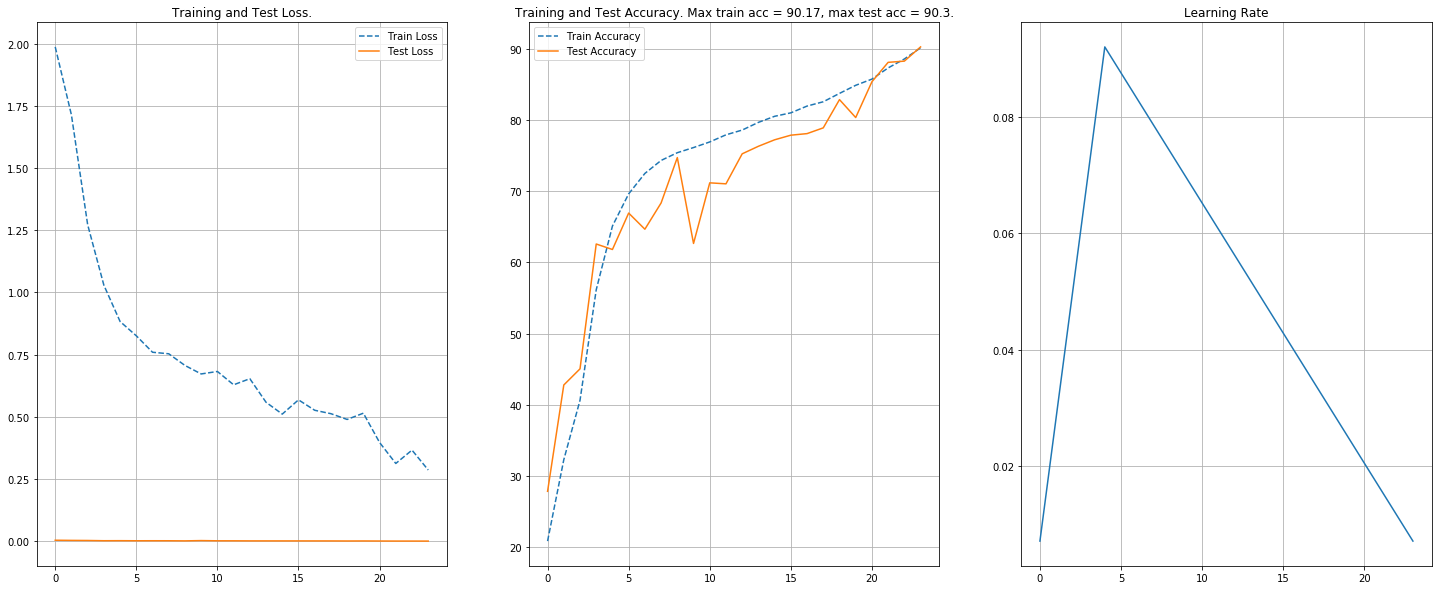

In [10]:
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True,epochs=epoch,doProcessArray=False)

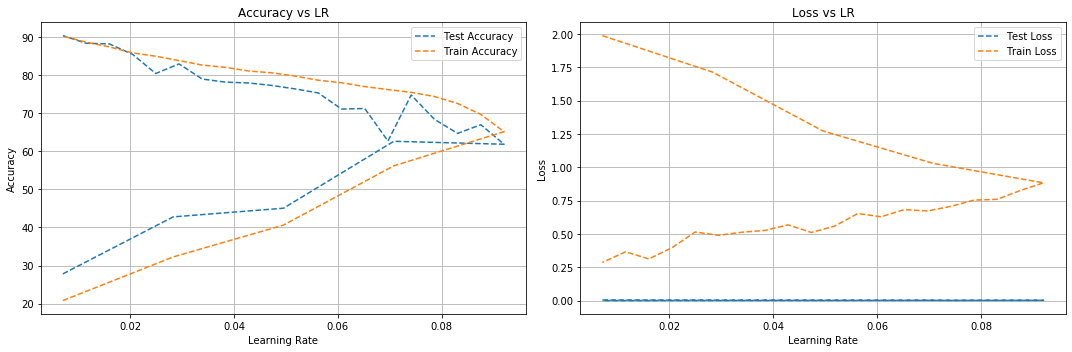

In [11]:
plotdata.PlotData.plotlrrangetestgraph(lr_data,test_acc,train_acc,test_losses,train_losses)

In [12]:
import torch
import src.utils.utils as utils
import src.preprocessing.albumentationstransforms as preprocessing
preproc = preprocessing.AlbumentaionsTransforms()
import glob
from PIL import Image
from src.utils.modelutils import *
import src.visualization.plotdata as plotdata
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.customcompose as customcompose
import src.train.train_model as train
import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision


%load_ext tensorboard

In [13]:
print(torch.cuda.is_available())
saved_data, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc\
            , test_losses, lr_data, class_correct, class_total\
= utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")

True


In [ ]:
model, device = utils.Utils.createmodelresnet18(model_state_dict=model_state_dict)

In [ ]:
train_transforms, test_transforms = preprochelper.PreprocHelper.getpytorchtransforms((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
ds = dst.Dataset()
train_dataset = ds.gettraindataset(train_transforms)
test_dataset = ds.gettestdataset(test_transforms)

batch_size = 128
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
test_loader = dataloader.gettestdataloader()
train_loader = dataloader.gettraindataloader()

# obtain one batch of test images
dataiterator = iter(test_loader)
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()



In [ ]:
classified, misclassified = train.TrainModel.getinferredimagesfromdataset(dataiterator=dataiterator, model=model,
                                                                          classes=classes, batch_size=batch_size,
                                                                          number=25)

Gradcam of misclassified images for Layer 34, Conv2d, Output Shape = 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


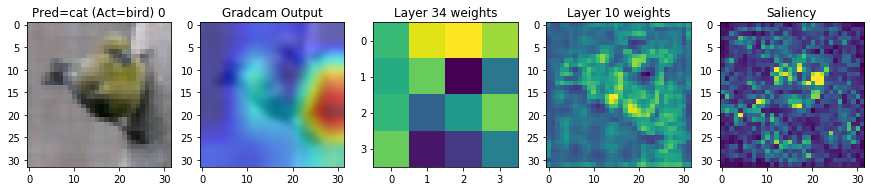

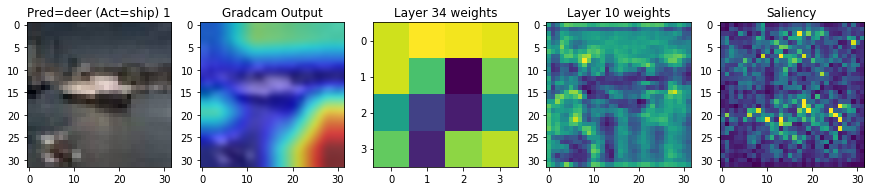

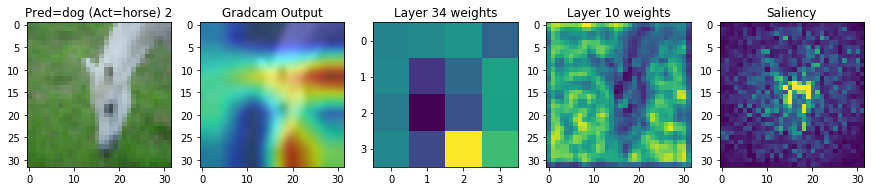

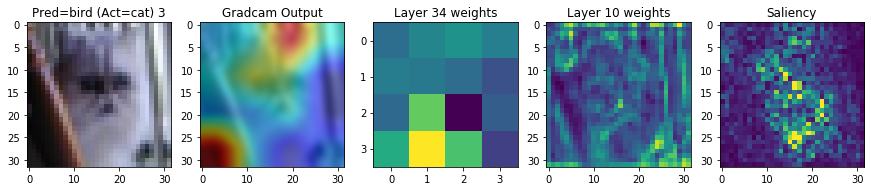

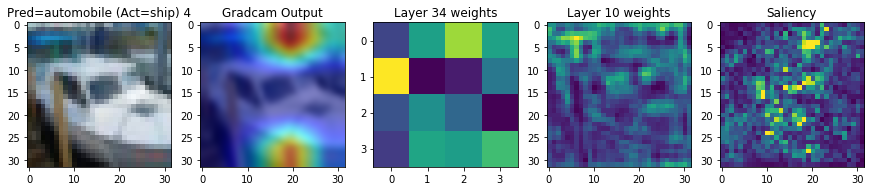

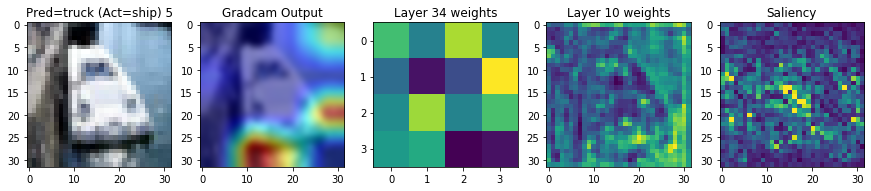

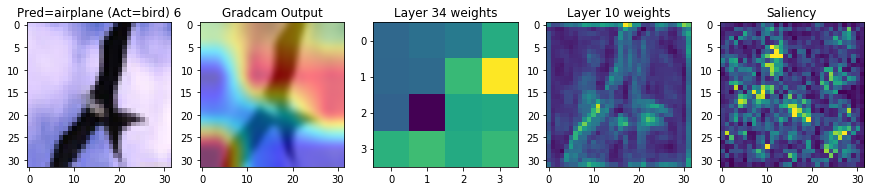

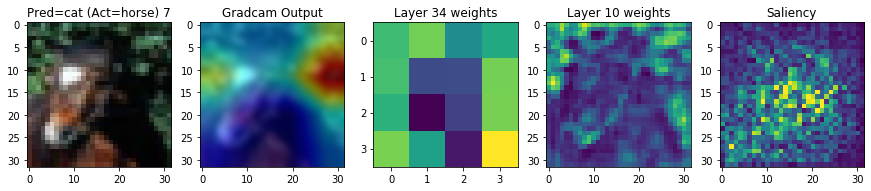

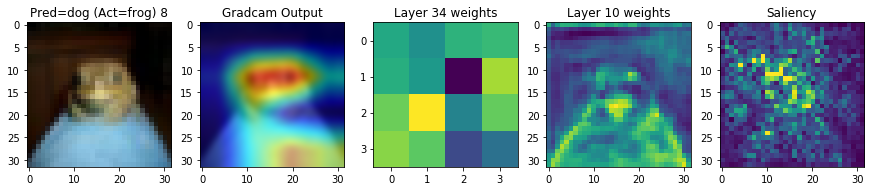

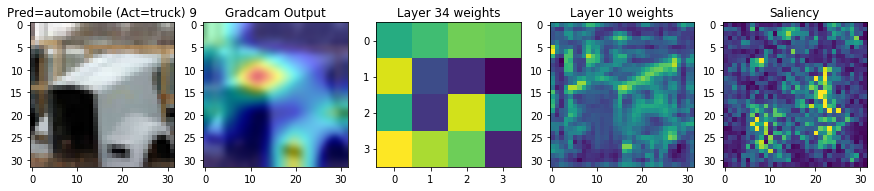

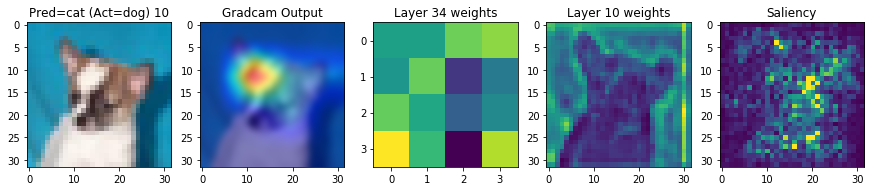

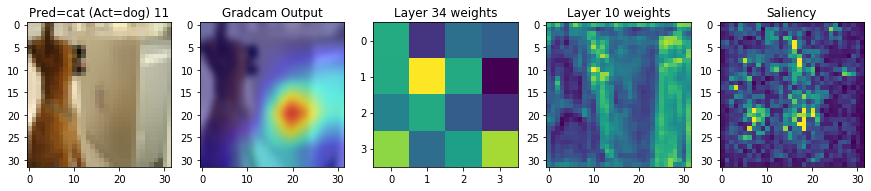

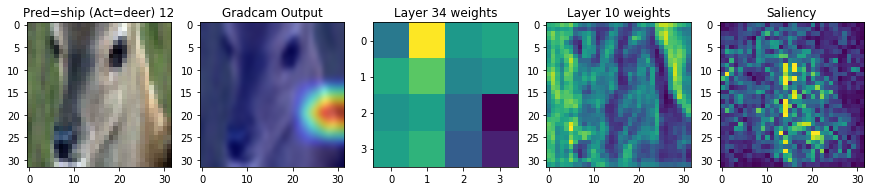

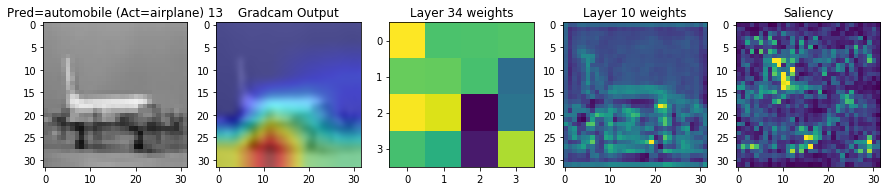

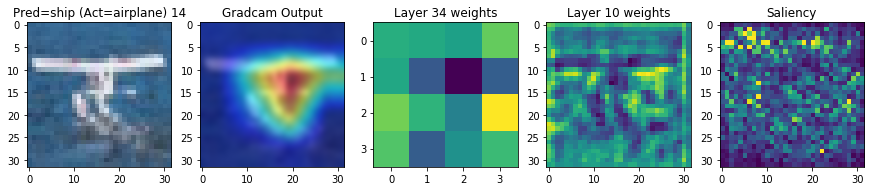

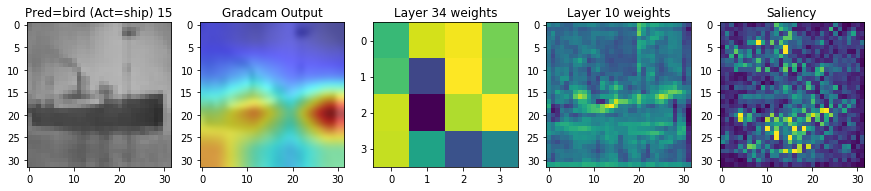

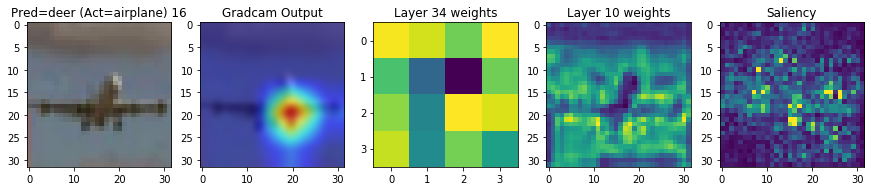

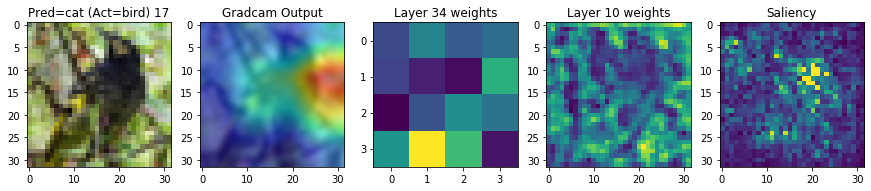

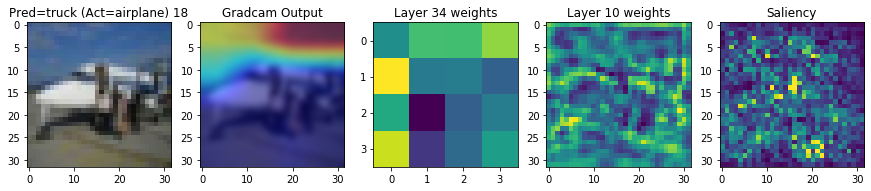

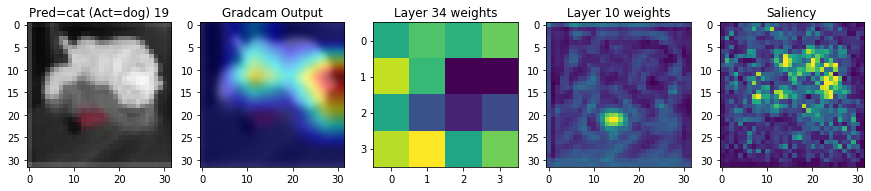

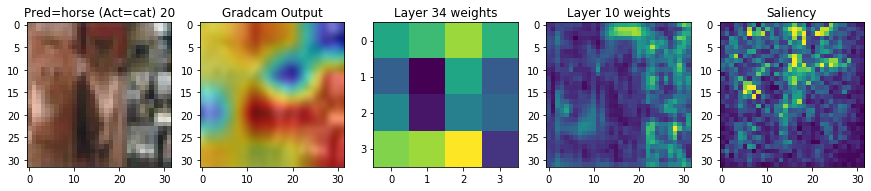

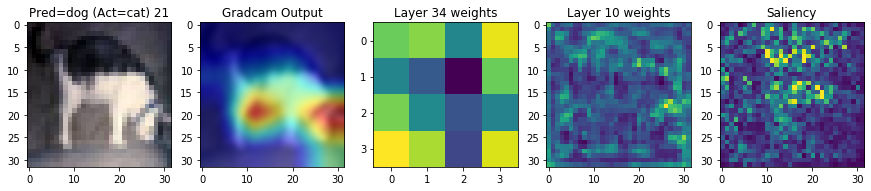

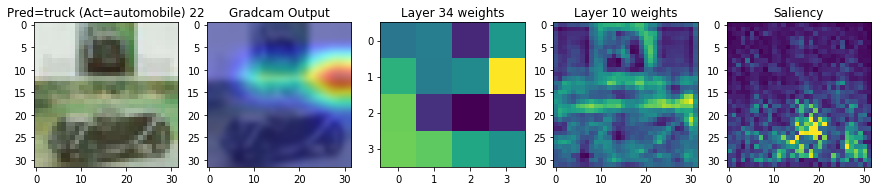

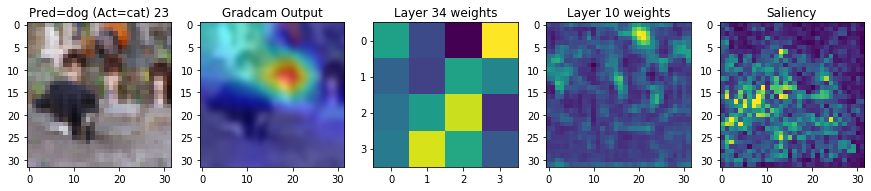

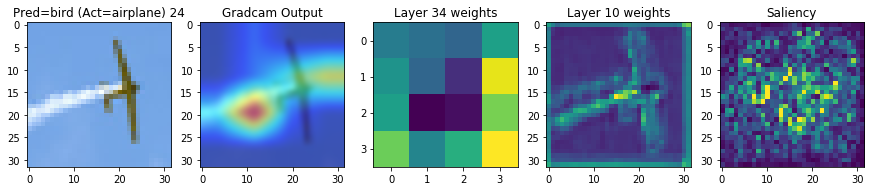

In [19]:
print("Gradcam of misclassified images for Layer 34, Conv2d, Output Shape = 8")

plotdata.PlotData.plotinferredimagesfromdataset(misclassified, model, device, classes,"misclassifed"
                                                ,size=(15,20),layerNo=34)

Gradcam of correct classified images for Layer 34, Conv2d, Output Shape = 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


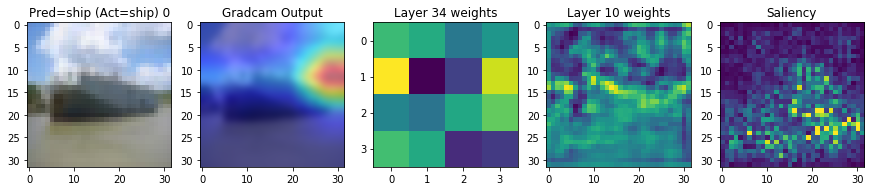

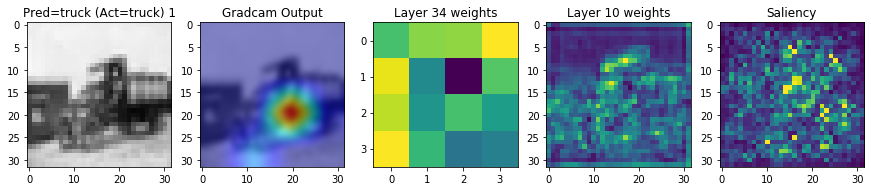

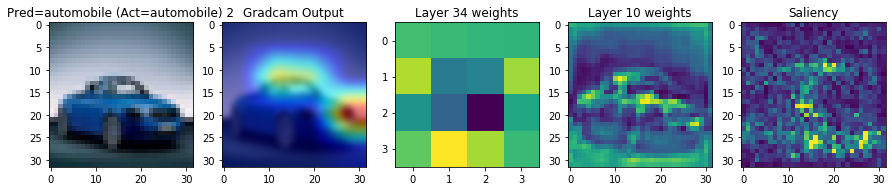

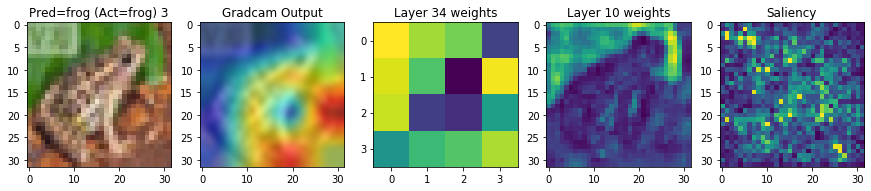

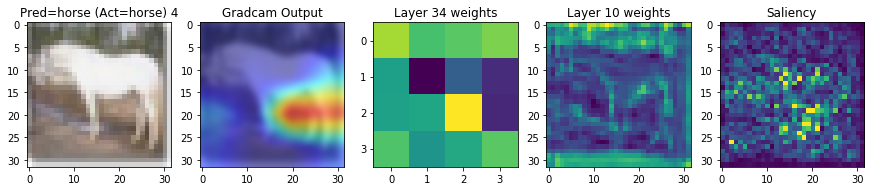

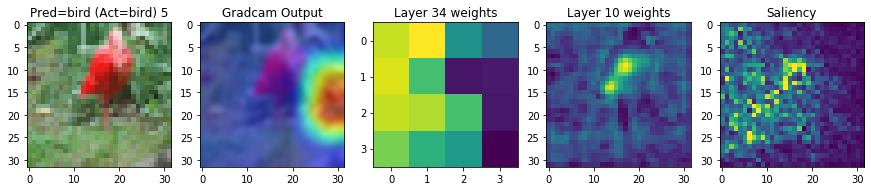

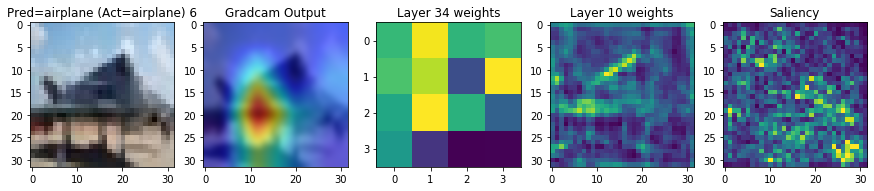

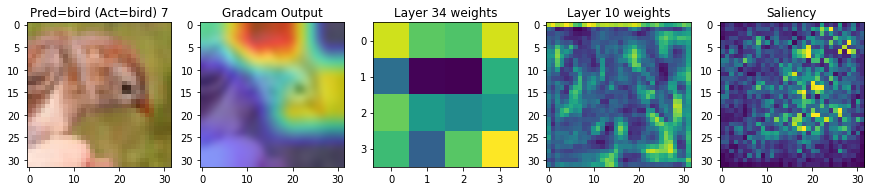

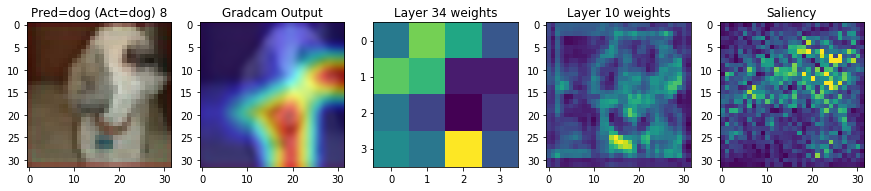

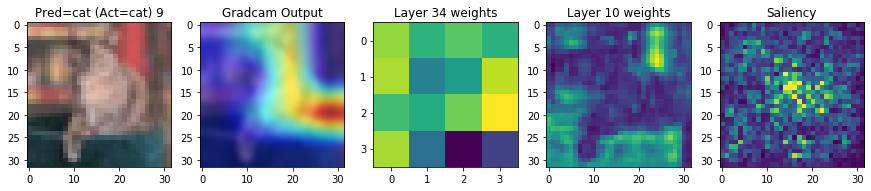

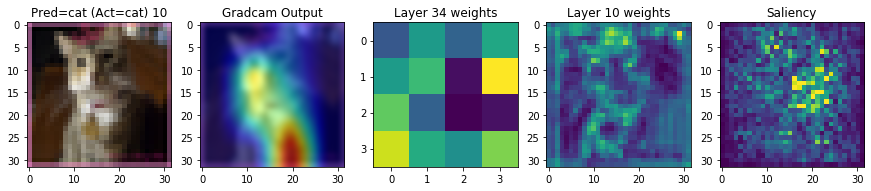

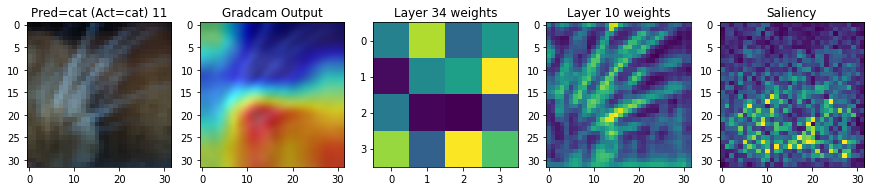

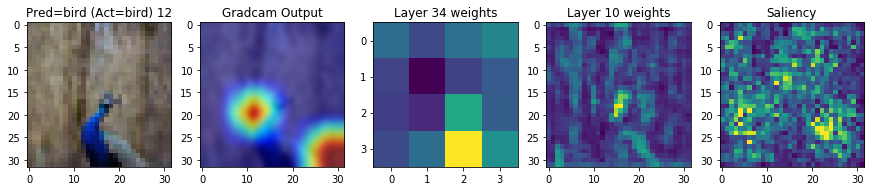

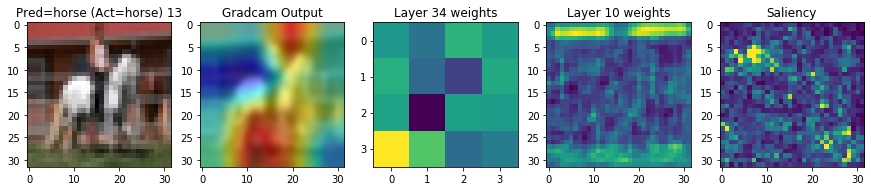

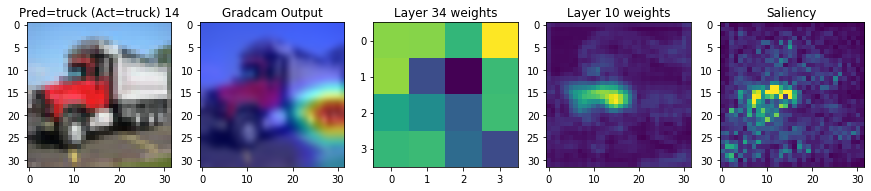

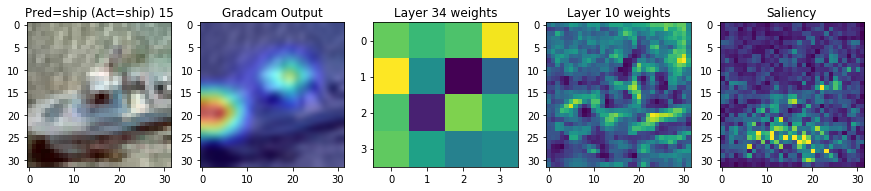

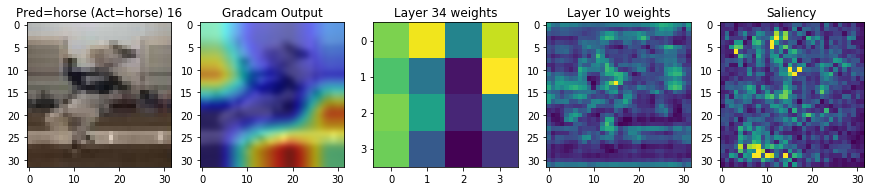

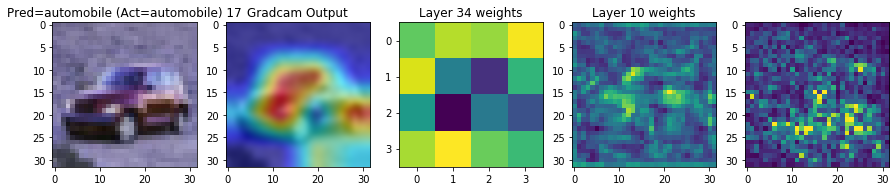

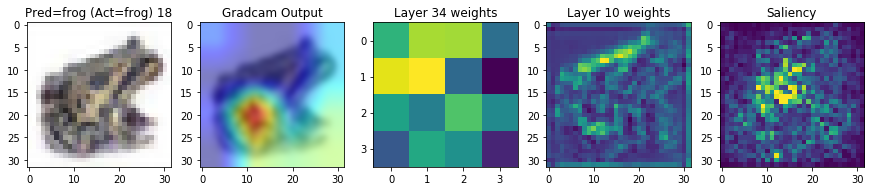

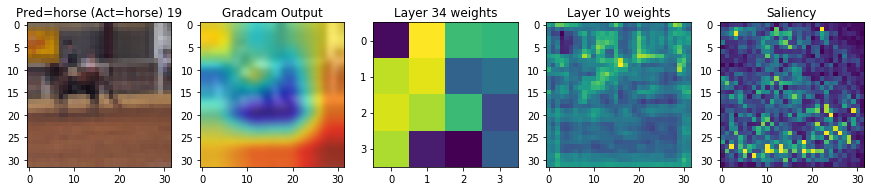

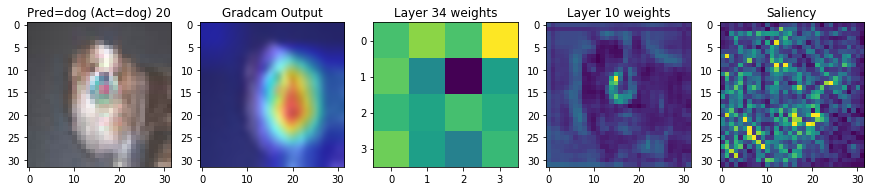

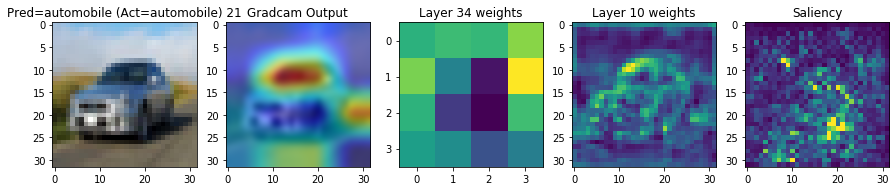

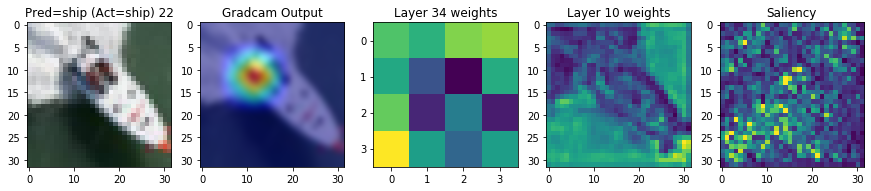

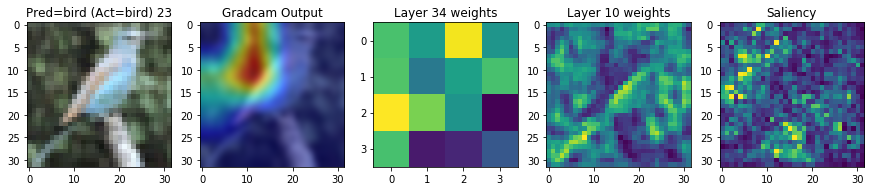

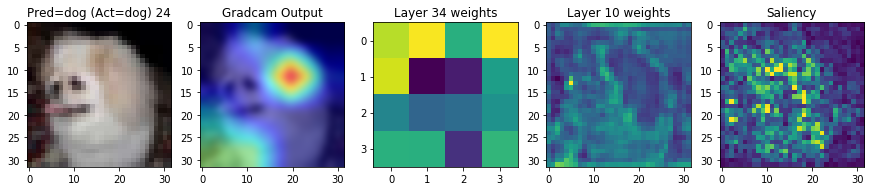

In [22]:
print("Gradcam of correct classified images for Layer 34, Conv2d, Output Shape = 8")

plotdata.PlotData.plotinferredimagesfromdataset(classified, model, device, classes,"correct"
                                                ,size=(15,20),layerNo=34)

In [7]:
utils.Utils.showaccuracyacrossclasses(class_correct=class_correct,class_total=class_total)

Test Accuracy of airplane: 85% (6787/7896)
Test Accuracy of automobile: 93% (7481/8034)
Test Accuracy of  bird: 77% (6164/7999)
Test Accuracy of   cat: 68% (5367/7815)
Test Accuracy of  deer: 80% (6374/7967)
Test Accuracy of   dog: 76% (6081/7911)
Test Accuracy of  frog: 88% (7051/7927)
Test Accuracy of horse: 87% (6846/7837)
Test Accuracy of  ship: 90% (7129/7843)
Test Accuracy of truck: 89% (6945/7771)

Test Accuracy (Overall): 83% (66225/79000)


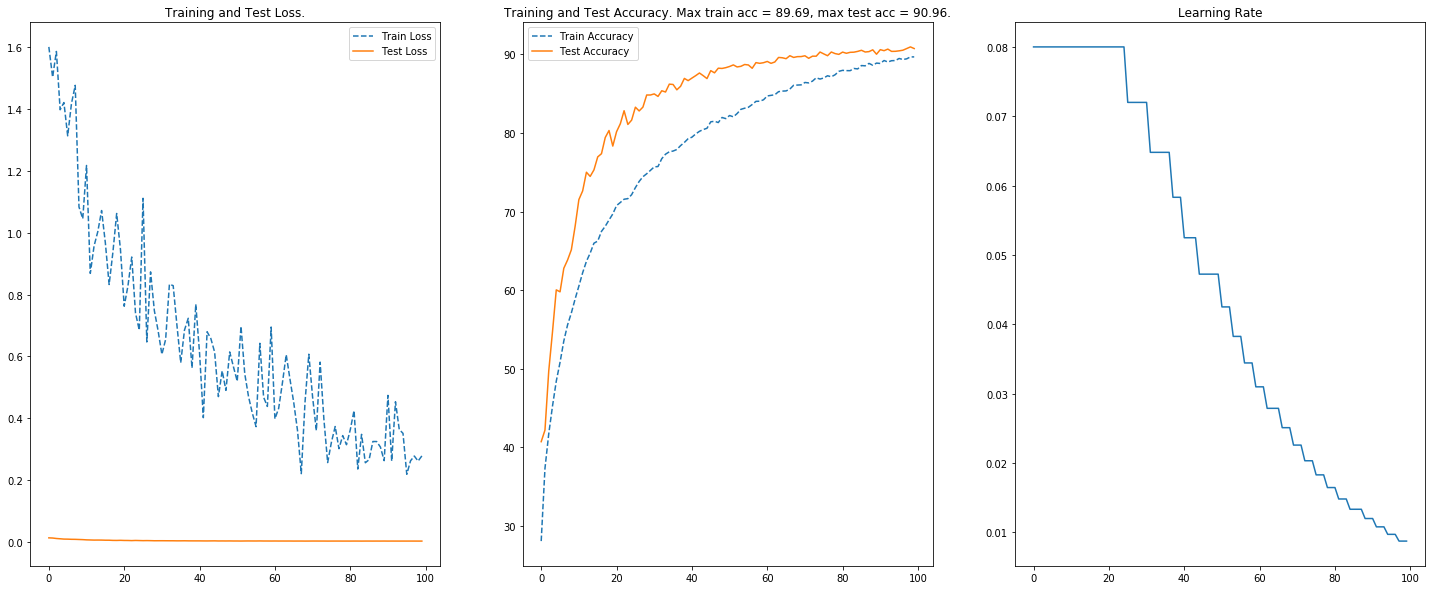

In [8]:
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True,epochs=epoch,doProcessArray=False)

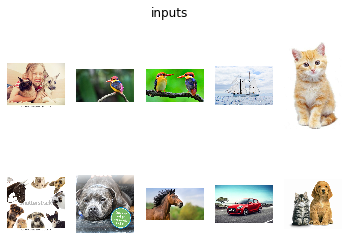

In [9]:
# from src.utils.modelutils import subplot
image_paths = glob.glob('./images/testimages/*.*')
images = list(map(lambda x: Image.open(x), image_paths))
subplot(images, title='inputs', nrows=2, ncols=5)

In [10]:
inputs = [torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])(
    x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

Gradcam of external images for Layer 34, Conv2d, Output Shape = 8


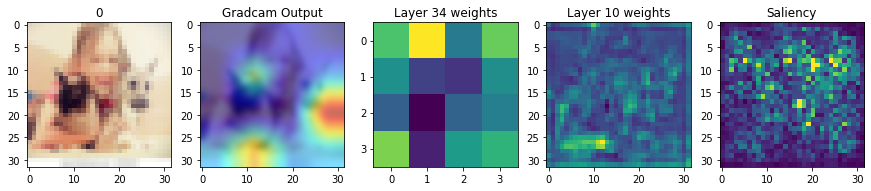

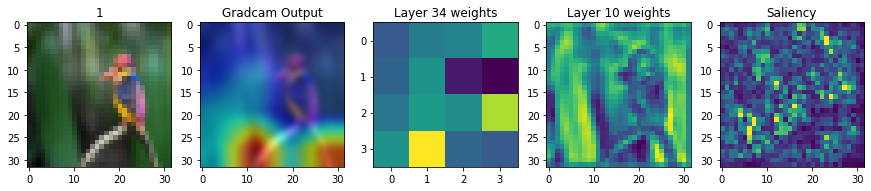

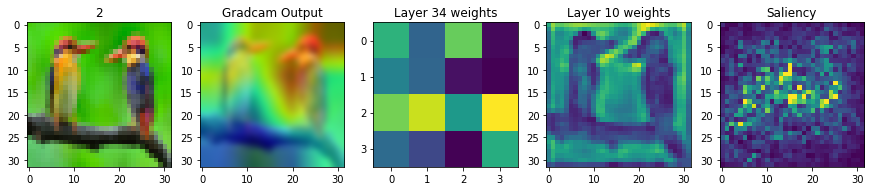

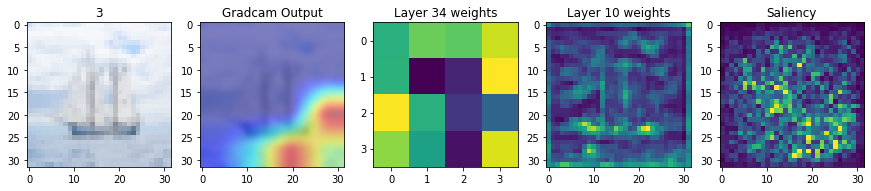

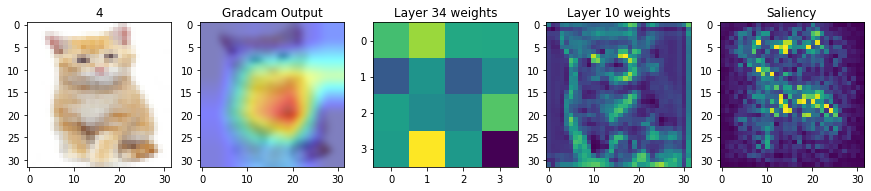

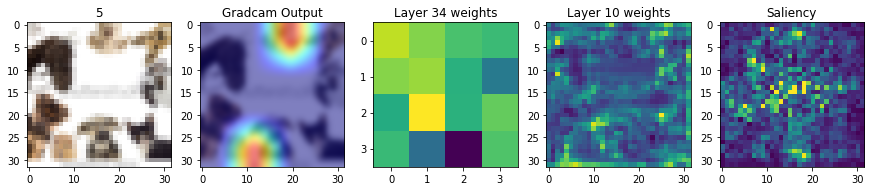

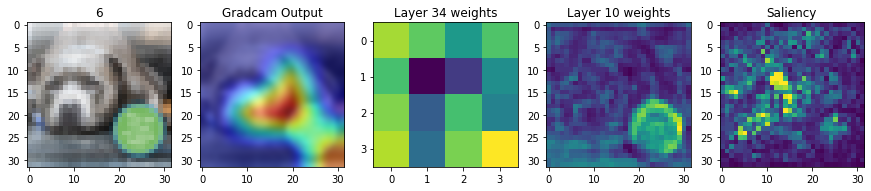

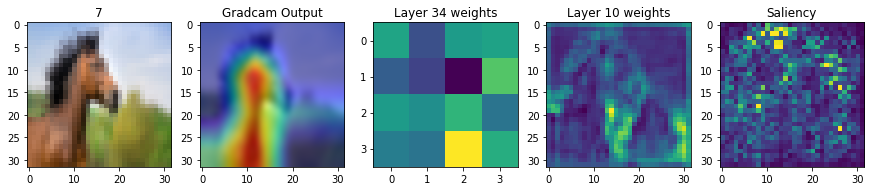

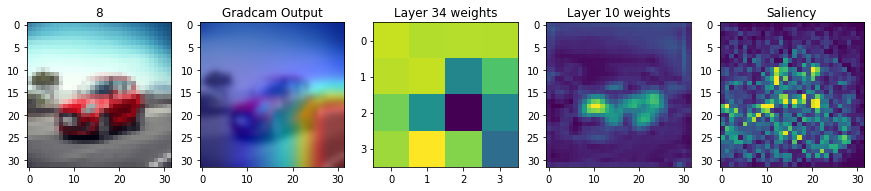

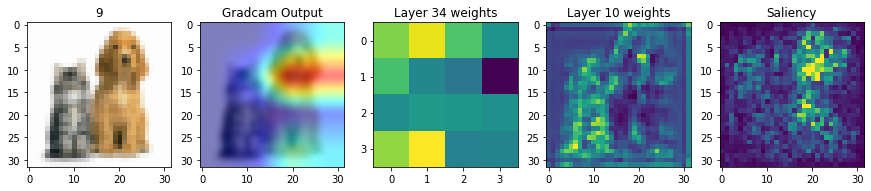

In [21]:
from src.visualization.gradcam.gradcam import GradCam
from src.visualization.gradcam import gradcamhelper

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


print("Gradcam of external images for Layer 34, Conv2d, Output Shape = 8")
loc = 0
for input in inputs:  
    dict = {loc:input}
    plotdata.PlotData.plotinferredimagesfromdataset(dict, model, device, classes,"external"
                                                ,size=(15,20),layerNo=34)
    loc += 1


In [17]:
images, labels = next(iter(train_loader))

In [18]:
# model, device = utils.Utils.createmodelresnet18(model_state_dict=model_state_dict)
images, labels = images.to(device), labels.to(device)
grid = torchvision.utils.make_grid(images)

In [7]:
epochs = epoch

In [22]:
writer = SummaryWriter("ReduceLR_Resnet18_albumentation_A11")
writer.add_image('images', grid, 0)
writer.add_graph(cnn_model, images)

In [24]:
# print(epochs)
# for epoch in range(0, epochs):
#     writer.add_scalars('Loss', {'Train': train_losses[epoch],'Test': test_losses[epoch],}, epoch+1)
#     writer.add_scalars('Accuracy', {'Train': train_acc[epoch],'Test': test_acc[epoch],}, epoch+1)
#     writer.add_scalar('LR', lr_data[epoch], epoch+1)
#     writer.add_histogram('Test Accuracy distribution', test_acc[epoch], epoch+1)
#     writer.add_histogram('Test Loss distribution', test_losses[epoch], epoch+1)
#     writer.add_histogram('Train Accuracy distribution', train_acc[epoch], epoch+1)
#     writer.add_histogram('Train Loss distribution', train_losses[epoch], epoch+1)
    
writer.close()

In [25]:
tensorboard --logdir=ReduceLR_Resnet18_albumentation_A11

Reusing TensorBoard on port 6008 (pid 4711), started 0:00:19 ago. (Use '!kill 4711' to kill it.)

In [32]:
# torch.cuda.empty_cache()

# test_dataset = None
# train_dataset = None
# test_loader = None
# train_loader = None

# import gc
# gc.collect()

43061